In [1]:
# Standard libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import pandas as pd
import random
import json
import PIL
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# TorchVision
from torchvision import transforms, models

# Utilities
from tqdm import tqdm

# Metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

clear_output()

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
SEED = 42
EPOCH = 10
LR = 0.01
ROOT_DIR = "/kaggle/input/fruit-recognition/train/train"

In [4]:
def get_image_dataframe(dataset_path):
    """
    Returns:
        pd.DataFrame: A DataFrame with columns ['Filepath', 'Label']
    """
    image_dir = Path(dataset_path)
    
    extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']
    filepaths = []
    for ext in extensions:
        filepaths.extend(image_dir.glob(f'**/{ext}'))

    labels = [fp.parent.name for fp in filepaths]

    df = pd.DataFrame({
        'Filepath': [str(fp) for fp in filepaths],
        'Label': labels
    })

    return df


In [5]:
df = get_image_dataframe(ROOT_DIR)
df

,Filepath,Label
0,/kaggle/input/fruit-recognition/train/train/Or...,Orange
1,/kaggle/input/fruit-recognition/train/train/Or...,Orange
2,/kaggle/input/fruit-recognition/train/train/Or...,Orange
3,/kaggle/input/fruit-recognition/train/train/Or...,Orange
4,/kaggle/input/fruit-recognition/train/train/Or...,Orange
...,...,...
16849,/kaggle/input/fruit-recognition/train/train/Ma...,Mango
16850,/kaggle/input/fruit-recognition/train/train/Ma...,Mango
16851,/kaggle/input/fruit-recognition/train/train/Ma...,Mango
16852,/kaggle/input/fruit-recognition/train/train/Ma...,Mango


In [6]:
path = Path(ROOT_DIR).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

33


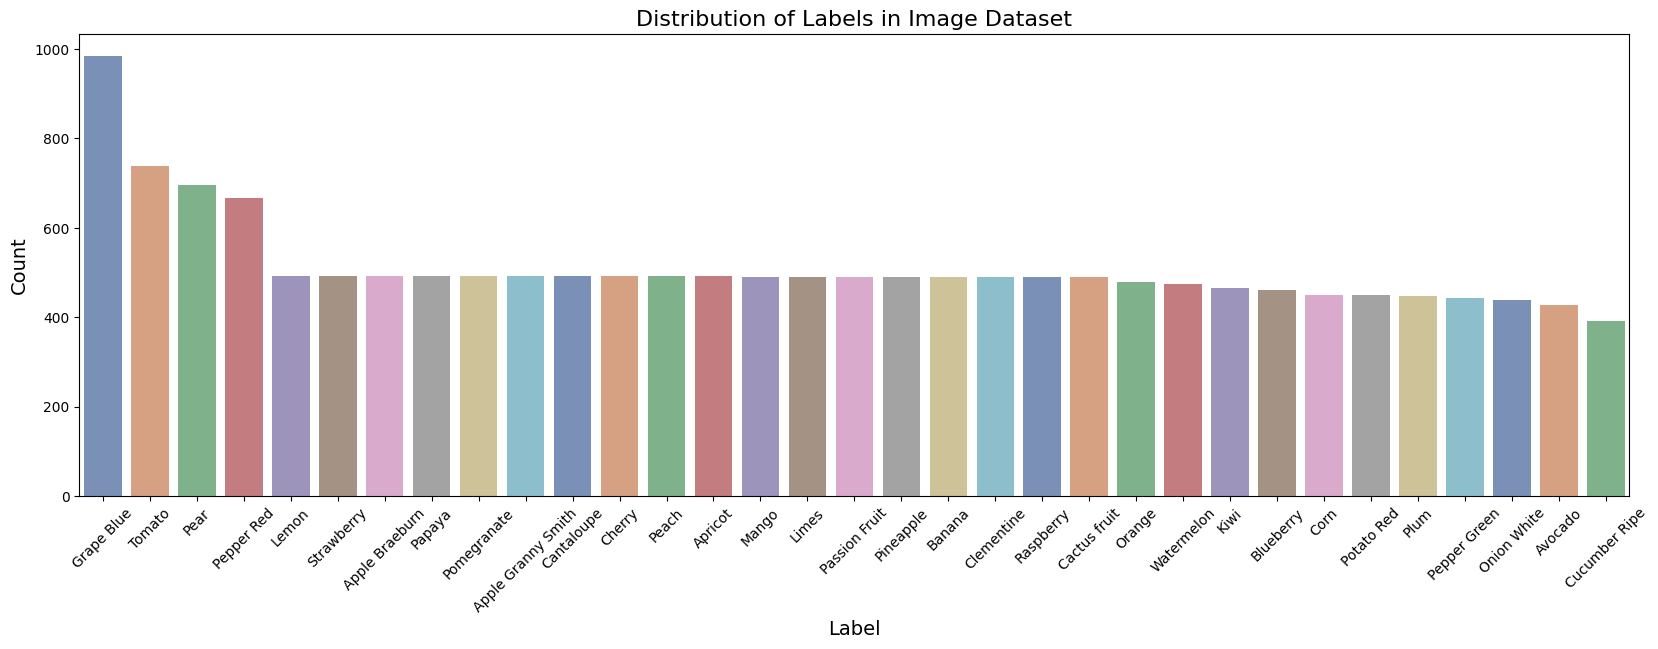

In [7]:
label_counts = df['Label'].value_counts()
print(len(label_counts))

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='deep')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()

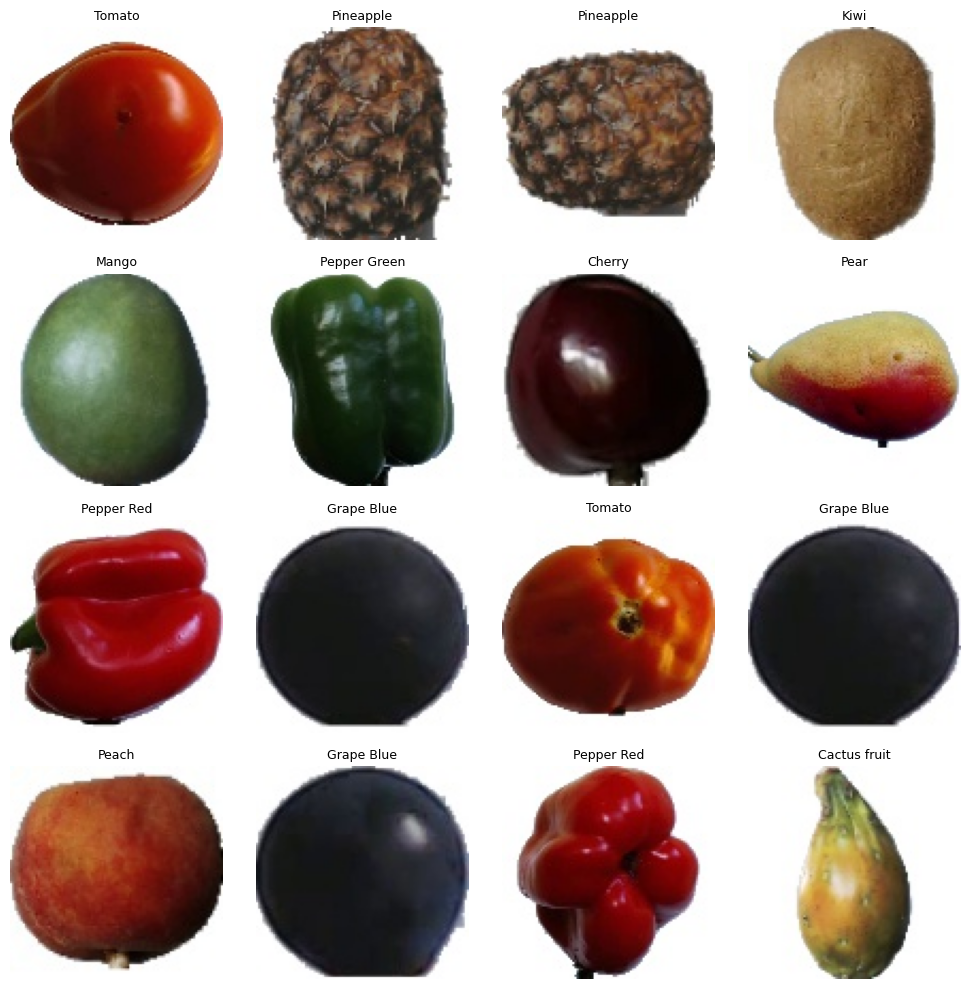

In [8]:
random_indices = np.random.randint(0, len(df), 16)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = plt.imread(df.Filepath[random_indices[i]])
    label = df.Label[random_indices[i]]
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [9]:
train_df, val_df = train_test_split(df, test_size=VAL_SPLIT, shuffle=True, random_state=42)
print(train_df.shape)
print(val_df.shape)

(13483, 2)
(3371, 2)


In [10]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class ImageDatasetFromDF(Dataset):
    def __init__(self, dataframe, transform=None, label_mapping=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_mapping = label_mapping or self._build_label_mapping()

    def _build_label_mapping(self):
        classes = sorted(self.dataframe['Label'].unique())
        return {label: idx for idx, label in enumerate(classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.loc[idx, 'Filepath']
        label_str = self.dataframe.loc[idx, 'Label']
        label = self.label_mapping[label_str]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [11]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

In [12]:
from torch.utils.data import DataLoader

train_dataset = ImageDatasetFromDF(train_df, transform=train_transform)
val_dataset = ImageDatasetFromDF(val_df, transform=val_transform, label_mapping=train_dataset.label_mapping)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Batch shape after transform: torch.Size([32, 3, 64, 64])
Shape of one image tensor: torch.Size([3, 64, 64])
Batch labels: tensor([ 2, 32,  8,  7, 19])


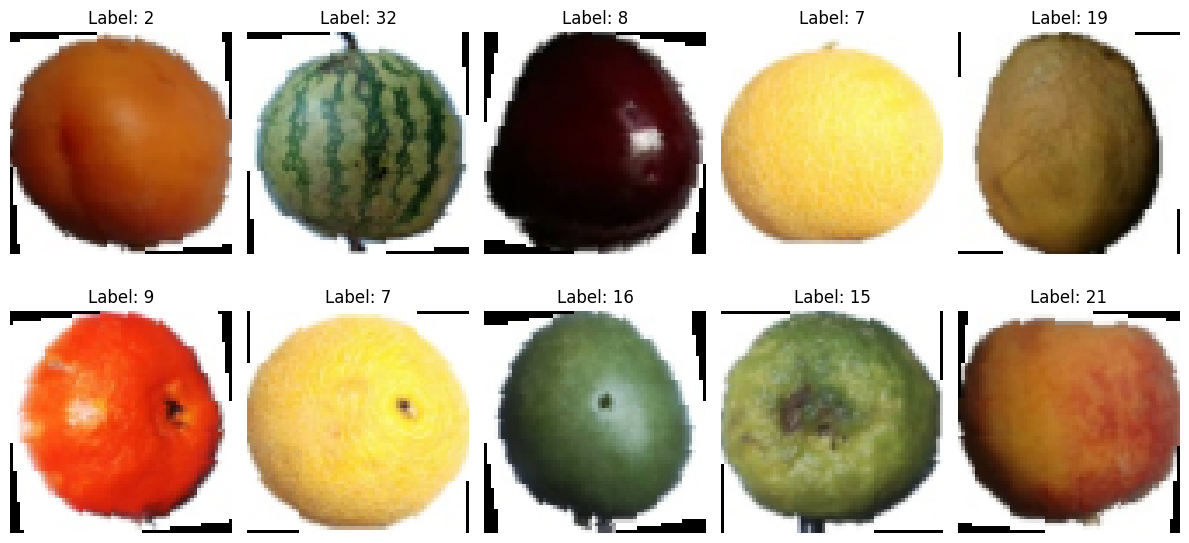

In [13]:
images, labels = next(iter(train_loader))

print("Batch shape after transform:", images.shape)
print("Shape of one image tensor:", images[0].shape)
print("Batch labels:", labels[:5])

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].numpy().transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)
    img = np.clip(img, 0, 1)  # Normalize to [0, 1] range
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [14]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=33):
        super(EfficientNetModel, self).__init__()

        self.base_model = models.efficientnet_b0(pretrained=True)

        # Freeze
        # for param in self.base_model.features.parameters():
        #     param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [15]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [16]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_precisions, val_recalls, val_f1s = [], [], []

for epoch in range(EPOCH):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_preds, val_labels = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch+1}/{EPOCH}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.2f}%, "
          f"Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]
100%|██████████| 422/422 [00:19<00:00, 21.28it/s]



Epoch 1/10: Train Loss=0.9871, Train Acc=72.08%, Val Loss=0.6113, Val Acc=81.99%, Precision=0.8766, Recall=0.8158, F1=0.8088


100%|██████████| 422/422 [00:18<00:00, 23.18it/s]



Epoch 2/10: Train Loss=0.2524, Train Acc=92.38%, Val Loss=0.1770, Val Acc=94.72%, Precision=0.9555, Recall=0.9461, F1=0.9425


100%|██████████| 422/422 [00:18<00:00, 23.25it/s]



Epoch 3/10: Train Loss=0.1383, Train Acc=95.91%, Val Loss=0.0195, Val Acc=99.50%, Precision=0.9951, Recall=0.9947, F1=0.9949


100%|██████████| 422/422 [00:18<00:00, 22.94it/s]



Epoch 4/10: Train Loss=0.1200, Train Acc=96.54%, Val Loss=0.0488, Val Acc=98.93%, Precision=0.9904, Recall=0.9879, F1=0.9881


100%|██████████| 422/422 [00:18<00:00, 23.27it/s]



Epoch 5/10: Train Loss=0.1136, Train Acc=96.50%, Val Loss=0.0602, Val Acc=98.31%, Precision=0.9838, Recall=0.9834, F1=0.9825


100%|██████████| 422/422 [00:18<00:00, 23.01it/s]



Epoch 6/10: Train Loss=0.0637, Train Acc=98.16%, Val Loss=0.0080, Val Acc=99.82%, Precision=0.9982, Recall=0.9983, F1=0.9982


100%|██████████| 422/422 [00:18<00:00, 23.15it/s]



Epoch 7/10: Train Loss=0.1663, Train Acc=95.71%, Val Loss=0.0092, Val Acc=99.61%, Precision=0.9965, Recall=0.9955, F1=0.9959


100%|██████████| 422/422 [00:19<00:00, 22.04it/s]



Epoch 8/10: Train Loss=0.0421, Train Acc=98.98%, Val Loss=0.0023, Val Acc=99.88%, Precision=0.9989, Recall=0.9985, F1=0.9987


100%|██████████| 422/422 [00:18<00:00, 23.44it/s]



Epoch 9/10: Train Loss=0.1250, Train Acc=96.83%, Val Loss=0.0422, Val Acc=98.69%, Precision=0.9859, Recall=0.9887, F1=0.9864


100%|██████████| 422/422 [00:18<00:00, 23.43it/s]



Epoch 10/10: Train Loss=0.0398, Train Acc=98.96%, Val Loss=0.0038, Val Acc=99.91%, Precision=0.9991, Recall=0.9991, F1=0.9991


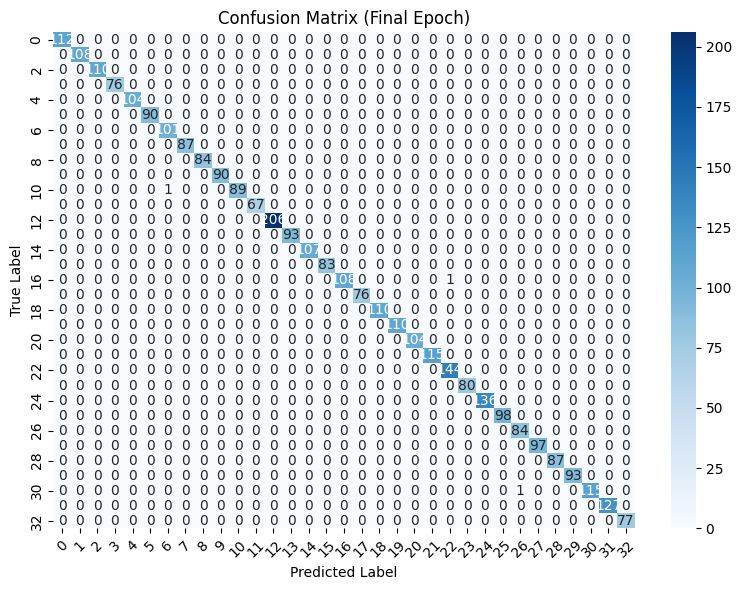

In [18]:
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Final Epoch)")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


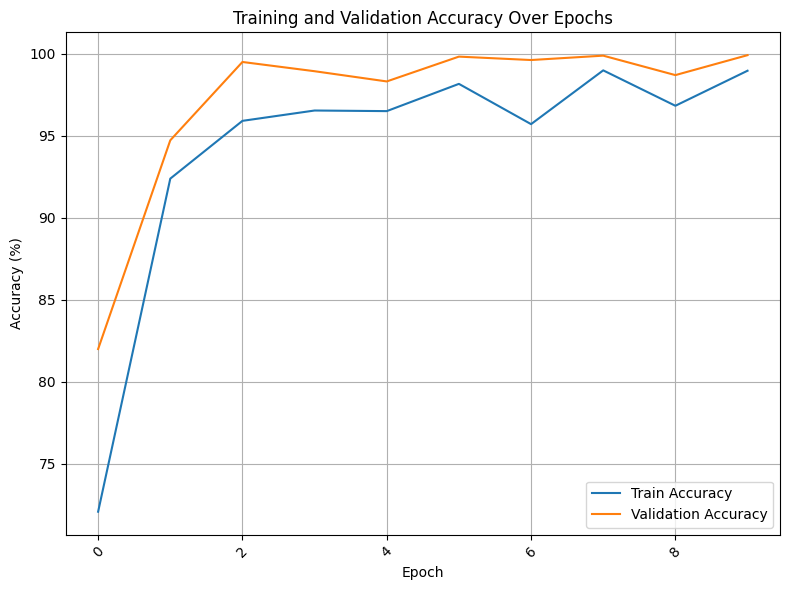

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()
